In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerTuple

In [2]:
# This is the microstate model, Ξ(pH) is the normalization constant of the probabilities,
# see [Ullman 2003] for details. The functions p00, p10, p01, p11 are equations 1-4
# in the paper. 

def Ξ(pH, pk10, pk01, W):
    return 1 + 10**(pk10 - pH) + 10**(pk01 - pH) + 10**(pk10 + pk01 - W - 2*pH)

def p00(pH, pk10, pk01, W):
    return 1/Ξ(pH, pk10, pk01, W)

def p10(pH, pk10, pk01, W):
    return (10**(pk10 - pH))/Ξ(pH, pk10, pk01, W)

def p01(pH, pk10, pk01, W):
    return (10**(pk01 - pH))/Ξ(pH, pk10, pk01, W)

def p11(pH, pk10, pk01, W):
    return (10**(pk10 + pk01 - W - 2*pH))/Ξ(pH, pk10, pk01, W)

# Fit all data simultaneously
def combined_func(x, pk10, pk01, W):
    pH = x
    return np.concatenate([p00(pH, pk10, pk01, W), 
                           p10(pH, pk10, pk01, W), 
                           p01(pH, pk10, pk01, W), 
                           p11(pH, pk10, pk01, W)])

In [3]:
# The total titration curve, equation 9 in the paper

def total_titration(pH, pk10, pk01, W):
    return (10**(pk10 - pH) + 10**(pk01 - pH) + 2*10**(pk10 + pk01 - W - 2*pH))/(1 + 10**(pk10 - pH) + 10**(pk01 - pH) + 10**(pk10 + pk01 - W - 2*pH))

In [4]:
def fit_microstate_model(data_path, ph_range):
    x = ph_range
    x00 = np.loadtxt(f'{data_path}/p00.dat')
    x10 = np.loadtxt(f'{data_path}/p10.dat')
    x01 = np.loadtxt(f'{data_path}/p01.dat')
    x11 = np.loadtxt(f'{data_path}/p11.dat')


    y = np.concatenate([x00, x10, x01, x11])

    initial_guess = [7, 7, 0] 
    params, covariance = curve_fit(combined_func, x, y, p0=initial_guess, method='lm')  # I use the  Levenberg-Marquardt (LM) method

    # It returns a tuple of 5 arrays, The first is the fitting parameters and the rest 4 is the CpHMD/pH-REMD simulation data
    return params, x00, x10, x01, x11

In [5]:
def hill_equation(x, Vmax, Kd, n):
    return (Vmax * x**n) / (Kd**n + x**n)

def fit_experimental_data(x,y):
    initial_guess = [5.0, 2.0, 1.0]
    popt, pcov = curve_fit(hill_equation, x, y, p0=initial_guess, method='lm', maxfev=10000)
    Vmax_opt, Kd_opt, n_opt = popt
    x_fit = np.linspace(min(x), max(x), 100)
    y_fit = hill_equation(x_fit, Vmax_opt, Kd_opt, n_opt)
    return x_fit,y_fit

In [6]:
ph_range_sim = np.arange(1.0, 10.0, 0.5)
sim = fit_microstate_model("./simultaneous-data", ph_range_sim)
ph_range_dim = np.arange(1.0, 11.5, 0.5)
dim = fit_microstate_model("./2-split-data", ph_range_dim)
ph_range_tri = np.arange(2.0, 10.0, 0.5)
tri = fit_microstate_model("./3-split-data", ph_range_tri)

datasets = [
    (ph_range_sim, sim, 'Simultaneous Microstate Model'),
    (ph_range_dim, dim, '2-Split Microstate Model'),
    (ph_range_tri, tri, '3-Split Microstate Model')
]

[3.928875654200092, 5.488469637257895, 4.166439320681181]
[5.2756445464457835, 7.040565769025418, 5.289230752920857]


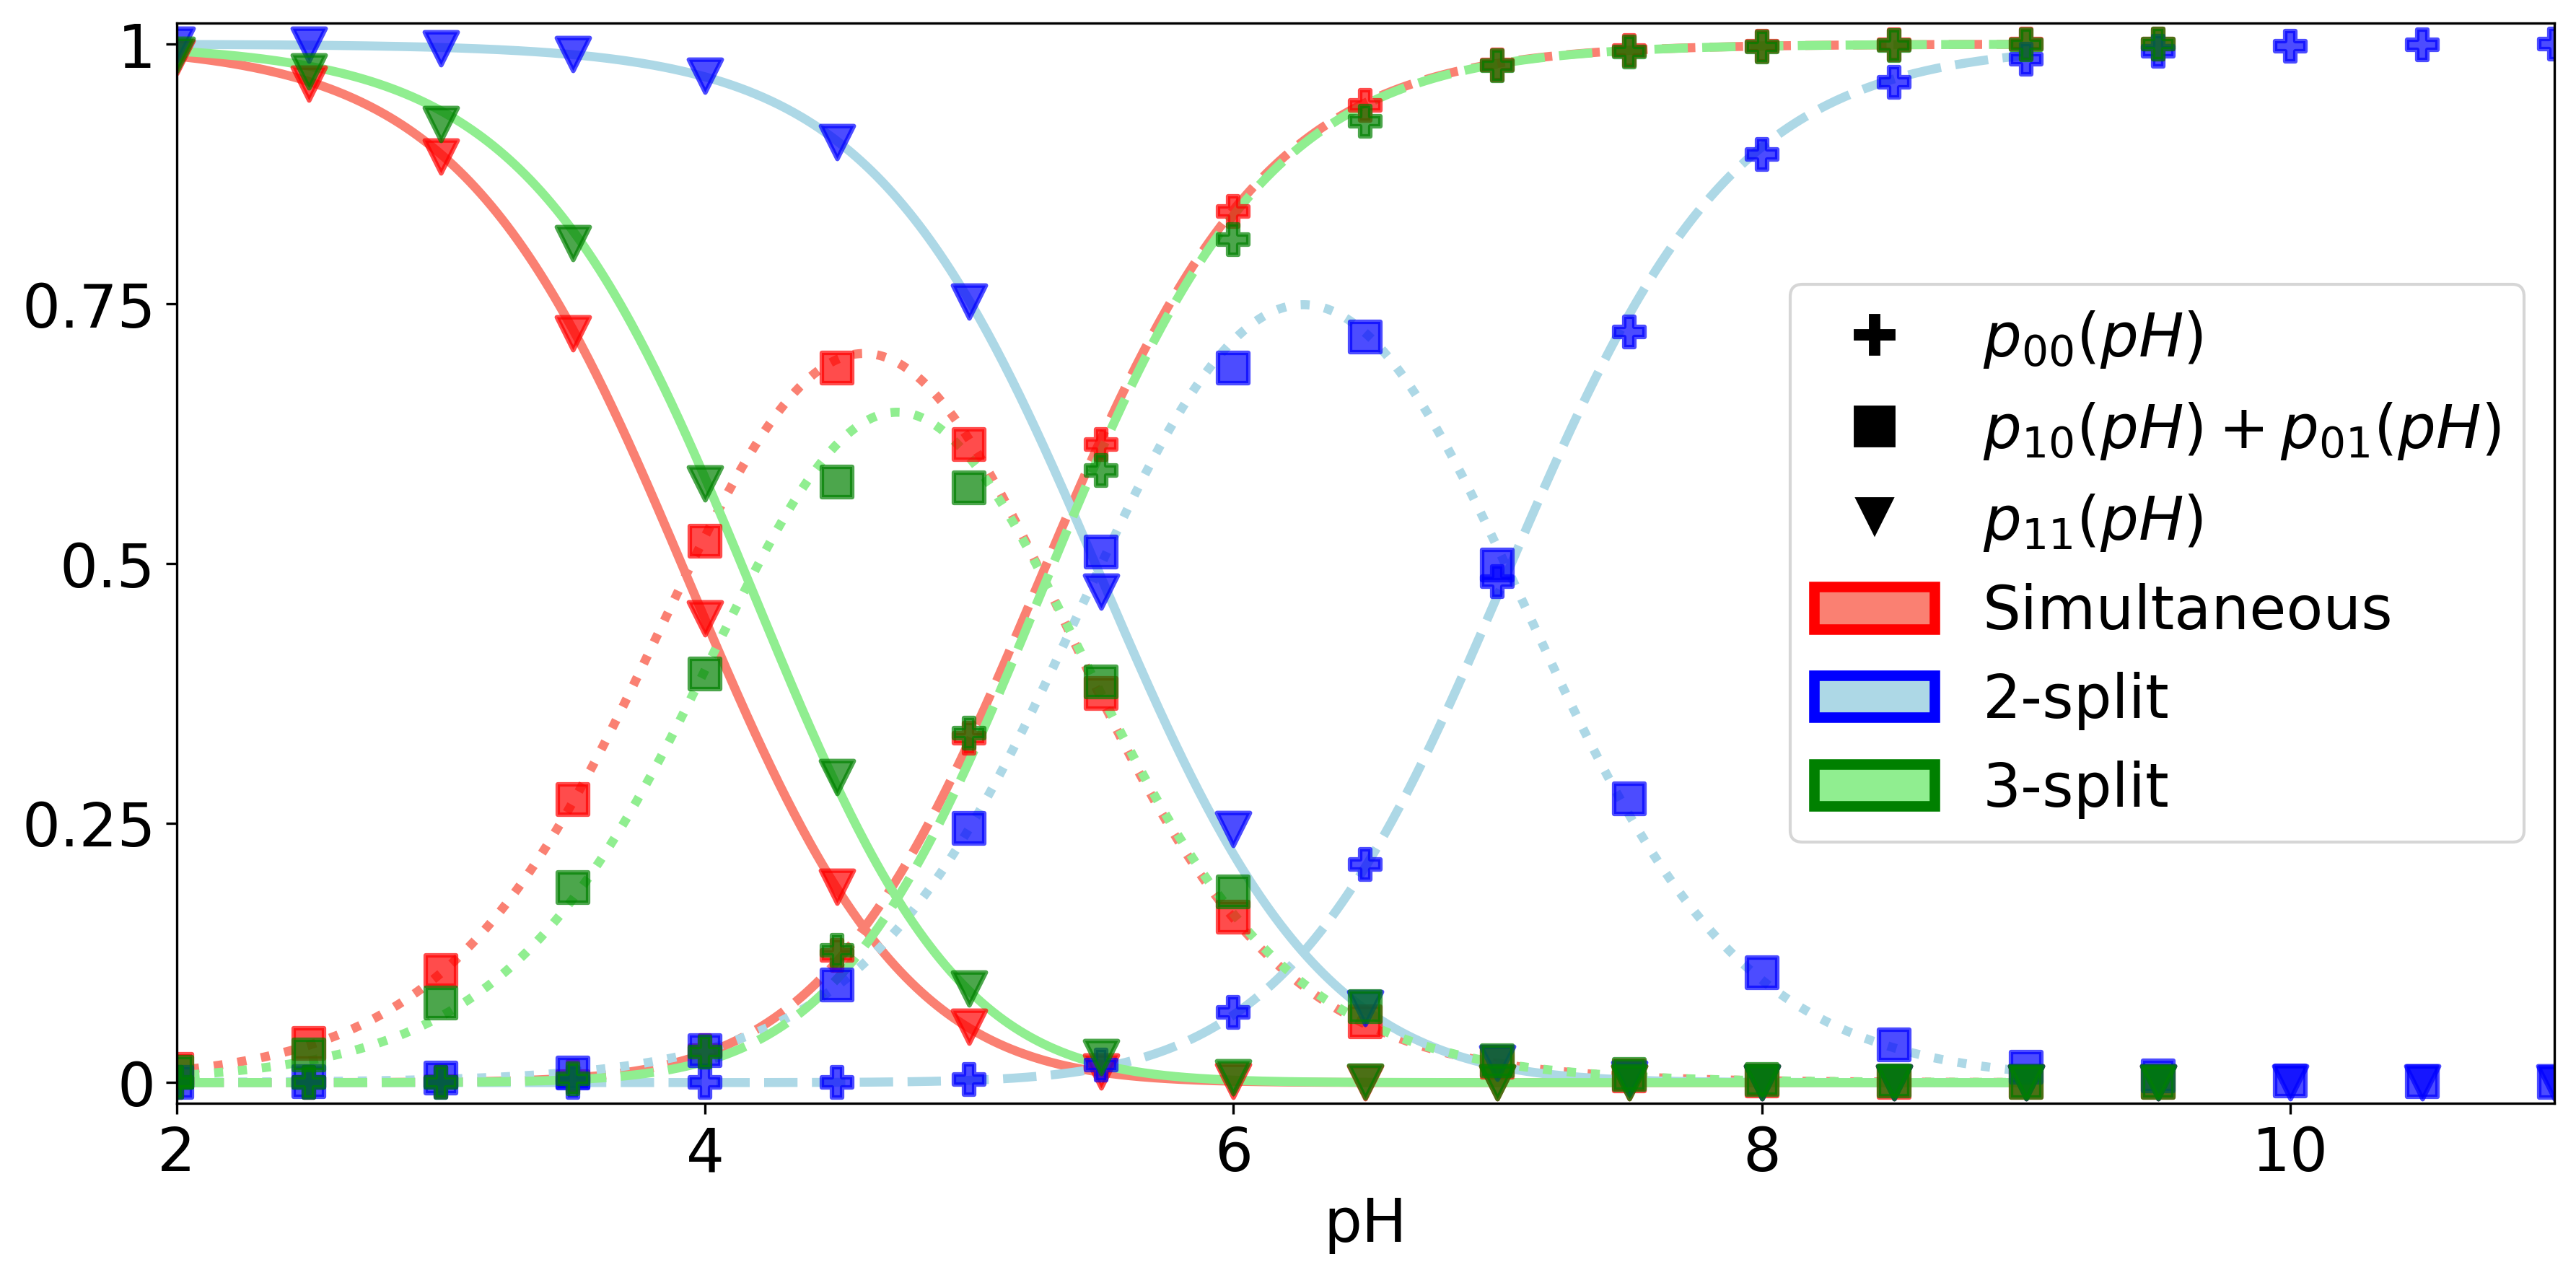

In [16]:
fig, axes = plt.subplots(figsize=(12,6), sharey=False,dpi=300)

# Create list of legend elements
legend_elements = []
legend_elements.append(Line2D([0], [0], marker='P', color='white', label=r'$p_{00}(pH)$', markerfacecolor='black', markersize=15))
legend_elements.append(Line2D([0], [0], marker='s', color='white', label=r'$p_{10}(pH) + p_{01}(pH)$', markerfacecolor='black', markersize=15))
legend_elements.append(Line2D([0], [0], marker='v', color='white', label=r'$p_{11}(pH)$', markerfacecolor='black', markersize=15))

# Define scatter and line colors
scatter_colors = ['r', 'b', 'g']
line_colors = ['Salmon', 'Lightblue', 'Lightgreen']
labels = ['Simultaneous', '2-split', '3-split']
pk1 = []
pk2 = []
pkT = []
# Add the color patches directly to the legend elements
for cat, face_col, scatter_col in zip(labels, line_colors, scatter_colors):
    legend_elements.append(mpatches.Patch(facecolor=face_col, label=cat, edgecolor=scatter_col,linewidth=3.5))

# Create the legend
leg = axes.legend(handles=legend_elements, ncol=1, loc='center right', prop={'size': 20})

# Loop through the datasets and create the subplots
for i, (ph_range, data, title) in enumerate(datasets):
    params, x00, x10, x01, x11 = data  # Unpack each dataset
    scatter_color = scatter_colors[i % len(scatter_colors)]
    line_color = line_colors[i % len(line_colors)]
    axes.scatter(ph_range, x00, color=scatter_color, s=100, alpha=0.7, linewidth=1.5, marker='P',zorder=2)
    axes.scatter(ph_range, x10+x01, color=scatter_color, s=100, alpha=0.7, linewidth=1.5, marker='s',zorder=2)
    #axes[i].scatter(ph_range, x01, color='black', s=100, alpha=0.7, edgecolor='black', linewidth=1.5)
    axes.scatter(ph_range, x11, color=scatter_color, s=120, alpha=0.7, linewidth=1.5, marker='v',zorder=2)

    pk1.append(np.log10((10**(params[0] + params[1] - params[2]))/(10**(params[0]) + 10**(params[1])))) # Equation 7 in the paper
    pk2.append(np.log10(10**params[0] + 10**params[1])) # Equation 8 in the paper 
    # Plot equations 1-4 together with the CpHMD data
    xn=np.arange(1,9,0.01)
    axes.plot(xn, p00(xn, params[0], params[1], params[2]), color=line_color, label=r'$p_{00}(pH)$', lw=3, linestyle='--',zorder=1)
    axes.plot(xn, p10(xn, params[0], params[1], params[2])+p01(xn, params[0], params[1], params[2]), color=line_color, label=r'$p_{10}(pH) + p_{01}(pH)$', zorder=1,lw=3, linestyle='dotted')
    #axes[i].plot(xn, p01(xn, params[0], params[1], params[2]), color='Gray', label=r'$p_{01}(pH)$', lw=4)
    axes.plot(xn, p11(xn, params[0], params[1], params[2]), color=line_color, label=r'$p_{11}(pH)$', lw=3,zorder=1)
#axes.set_title(title, fontsize=15)
axes.set_xlabel('pH', fontsize=20)
#axes.legend(loc='center right', prop={'size': 15}, frameon=False)
axes.set_xlim(2,11)
axes.set_ylim(-.02,1.02)
axes.tick_params(labelsize=20) 
axes.set_yticks([0,0.25,0.5,0.75,1.0])
axes.set_yticklabels(['0', '0.25', '0.5', '0.75', '1'])
axes.set_xticks([2,4,6,8,10])
axes.grid(False)


print(pk1)
print(pk2)
plt.tight_layout()
plt.show()
#plt.savefig(fr'./figure_1a.png', format='png', bbox_inches='tight')
#plt.savefig(fr'./figure_1a.svg', format='svg', bbox_inches='tight')

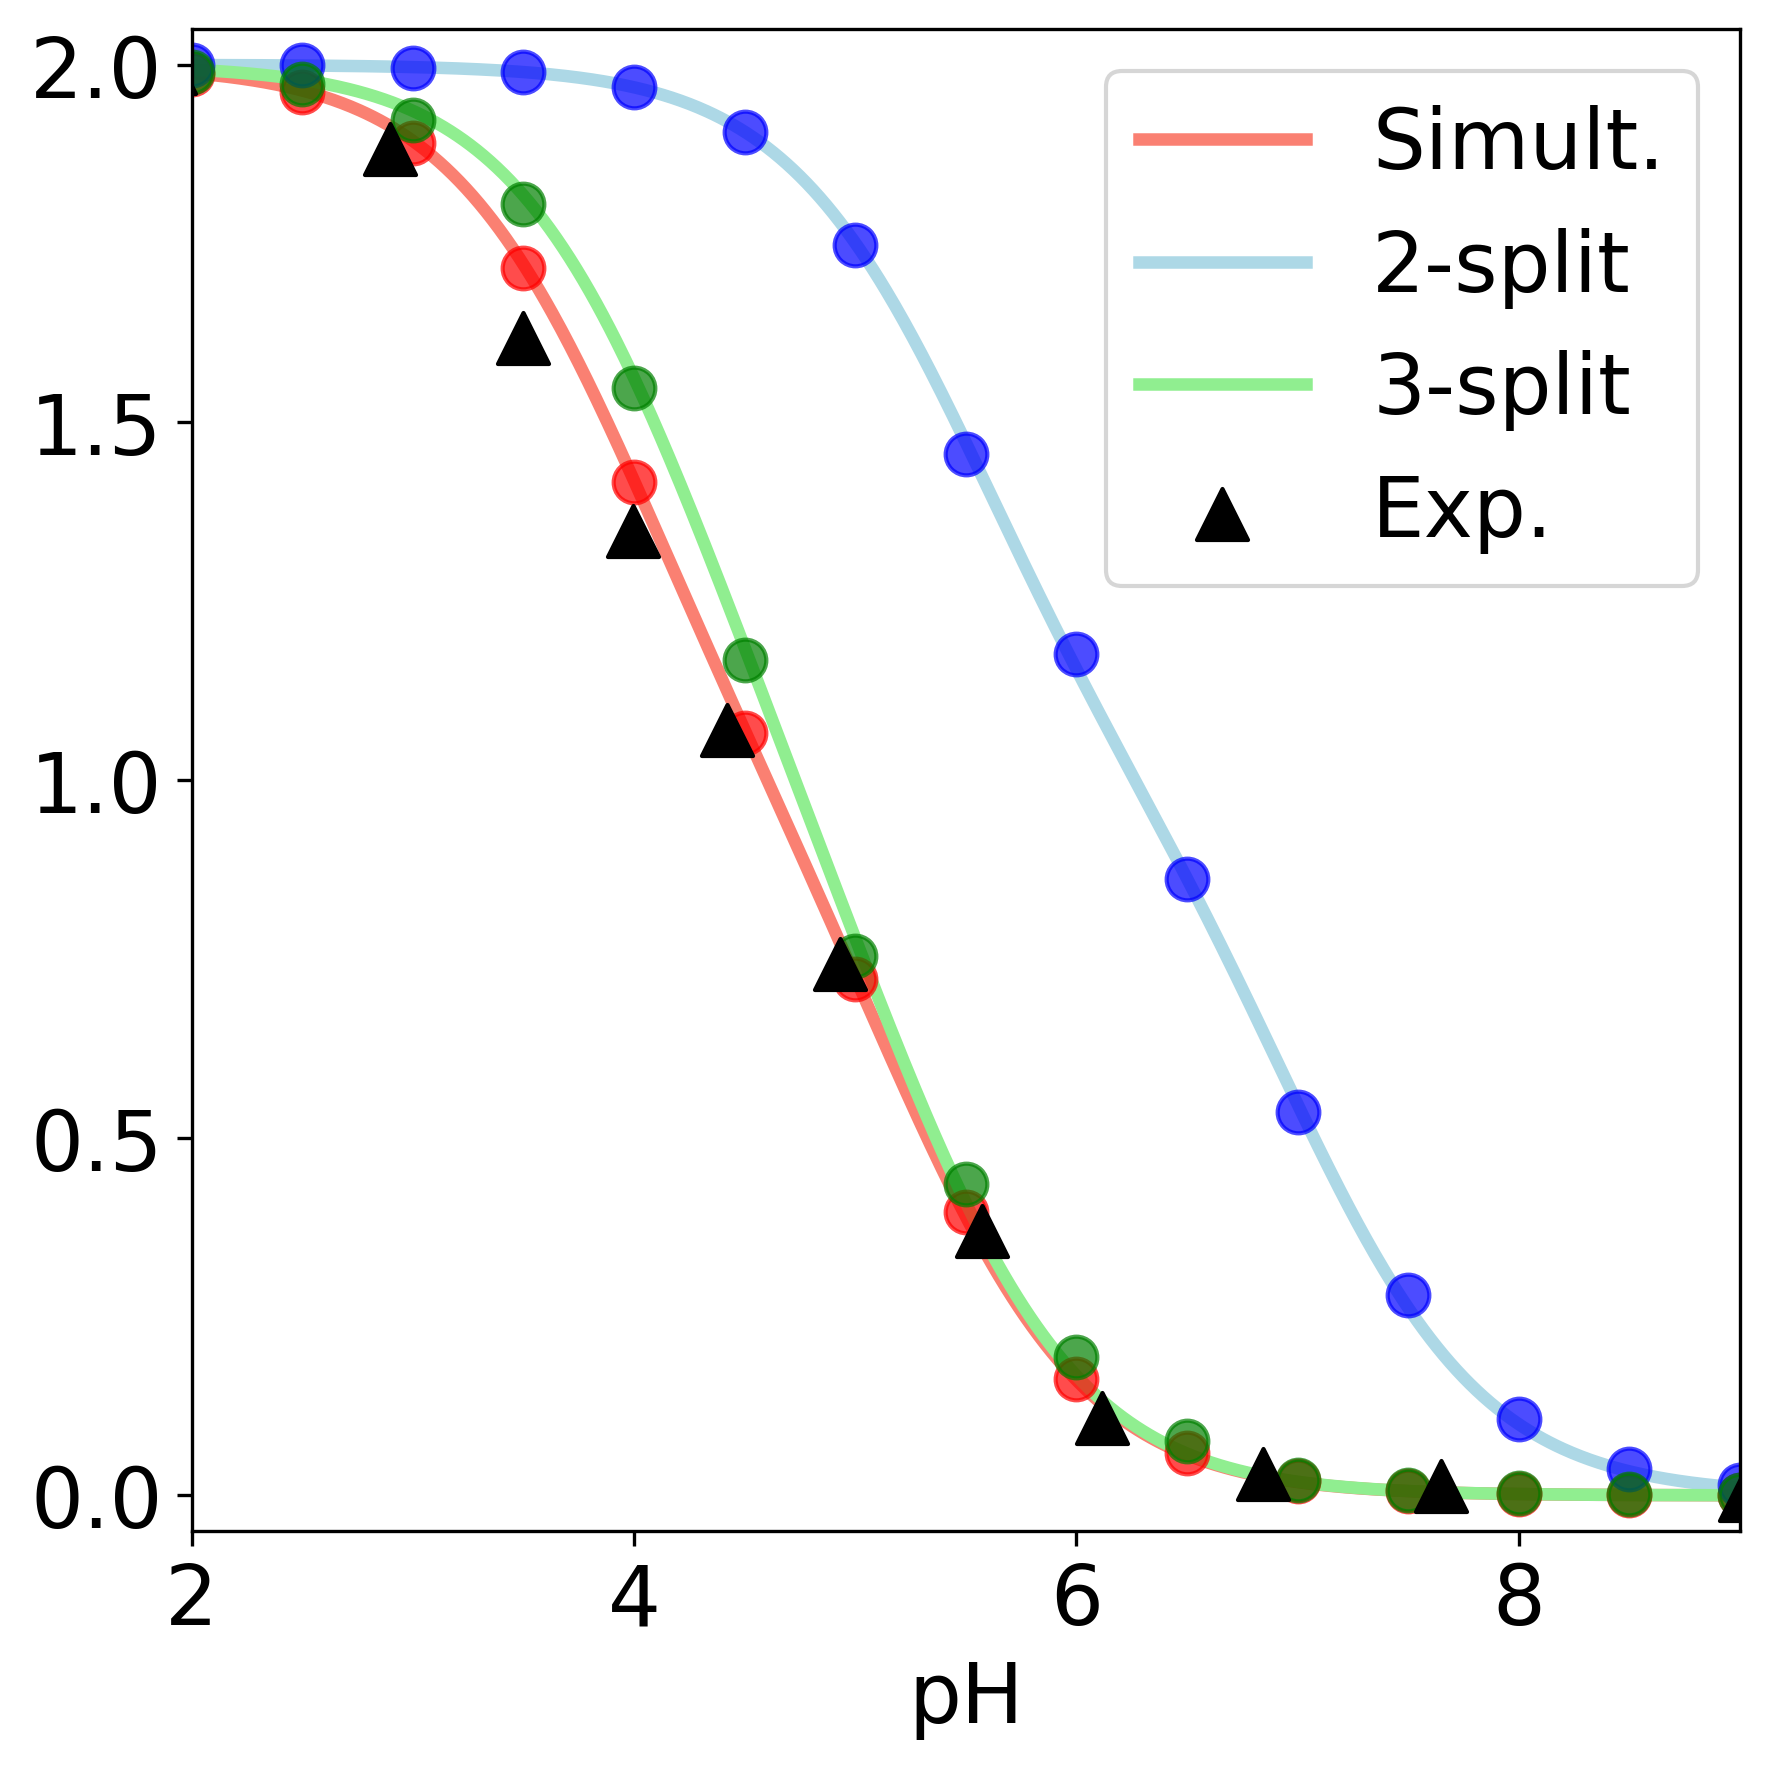

In [184]:
# Load the experimental macroscopic curve of biliverdin in water and fit a Hill equation to it

exp = np.genfromtxt('./experiment/exp_data.csv', delimiter=',')
fp = 1 - (exp[:, 1]  - np.min(exp[:, 1] )) / (np.max(exp[:, 1] ) - np.min(exp[:, 1] ))
#curve = fit_experimental_data(exp[:, 0], 2*fp)

g = lambda x, n, pka: 1 / (1 + 10**(n * (x - pka)))
n, pka = curve_fit(g, exp[:, 0], fp, p0=[1, 5])[0]

fig, axes = plt.subplots(figsize=(6, 6), sharey=False,dpi=300)

linestyles=['-', '-', '-']
labels=['Simult.', '2-split', '3-split']
scatter_colors = ['red', 'blue',  'green']
line_colors = ['Salmon', 'Lightblue',  'Lightgreen']
for i, (ph_range, data, title) in enumerate(datasets):
    params, x00, x10, x01, x11 = data
    X = x10 + x01 + 2*x11
    axes.scatter(ph_range, X, color=scatter_colors[i], s=100, zorder=2, alpha=0.7)
    axes.plot(xn, total_titration(xn, params[0], params[1], params[2]), label=labels[i], linestyle=linestyles[i], color=line_colors[i], lw=3, zorder=1)
#    axes.set_title('Total titration of the three models', fontsize=15)
    axes.set_xlabel('pH', fontsize=20)
    axes.set_xlim(2,9)
    axes.set_ylim(-0.05,2.05)
    axes.tick_params(labelsize=20) 
    axes.set_yticks([0,0.5,1,1.5,2.0])
    axes.grid(False)
    
axes.scatter(exp[:, 0], 2*fp, label='Exp.', s=150, color='black',marker='^',zorder=2)
#axes.plot(curve[0], curve[1], , color='grey', lw=3, zorder=1)
axes.legend(loc='best', prop={'size': 20}, frameon=True)
plt.tight_layout()
#plt.show()
plt.savefig(fr'./figure_1b.png', format='png', bbox_inches='tight')
plt.savefig(fr'./figure_1b.svg', format='svg', bbox_inches='tight')